In [4]:
import os
from pathlib import Path
# Check if the code is running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    base_path = "/content/"
    if Path(f"{base_path}final_project").is_dir():
      %cd {base_path}final_project
      !git pull
      %cd {base_path}
    else:
      !git clone https://github.com/fernandaluft/final_project.git
except ImportError:
    IN_COLAB = False
    base_path = "/workspaces/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scraping import Scraping
import os
import plotly.express as px
from wordcloud import WordCloud
import kaleido

In [ ]:
scraping = Scraping(IN_COLAB, books_reviews_ds = True)
scraping.kaggle_scrape()

In [8]:
!unzip /workspaces/final_project/preprocessed_data/xaa_books_reviews.zip

Archive:  /workspaces/final_project/preprocessed_data/xaa_books_reviews.zip
  inflating: content/final_project/data/books_reviews.csv  


In [5]:
limit = 200000
dataset_limit=60000

In [9]:
class Eda():
    def __init__(self, limit, dataset_limit):
        self.dataset_limit = dataset_limit
        self.limit = limit
        os.makedirs(f'{base_path}final_project/charts', exist_ok=True)
        os.makedirs(f'{base_path}final_project/preprocessed_data', exist_ok=True)

    def merge_datasets(self):
        if self.limit != None:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv').sample(self.limit)
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv').sample(self.limit)
        else:
          self.df1 = pd.read_csv(f'{base_path}final_project/data/books_data.csv')
          self.df2 = pd.read_csv(f'{base_path}final_project/data/Books_rating.csv')
        self.books_df = self.df1.merge(self.df2, left_on='Title', right_on='Title', how='inner')
        self.books_df = self.books_df.sample(self.dataset_limit)
        self.books_df.to_csv(f"{base_path}final_project/data/books_reviews.csv", index=False)
        os.system(f'zip -r {base_path}final_project/preprocessed_data/books_reviews.zip {base_path}final_project/data/books_reviews.csv')
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.csv')
        command = "split -b 100M '{}' --additional-suffix=_{}".format(f'{base_path}final_project/preprocessed_data/books_reviews.zip', os.path.basename(f'{base_path}final_project/preprocessed_data/books_reviews.zip'))
        os.system(command)
        !mv {base_path}*_books_reviews.zip {base_path}final_project/preprocessed_data/
        os.system(f'rm -rf {base_path}final_project/preprocessed_data/books_reviews.zip')

        return self.books_df

    def explore(self):
        self.books_df = pd.read_csv(f"{base_path}final_project/data/books_reviews.csv")
        print(f'Dataset Info:\n {self.books_df.info()}')
        print(f'Number of duplicates:\n {self.books_df.duplicated().sum()}')
        print(f'Null values:\n {self.books_df.isnull().sum()}')
        sns.heatmap(self.books_df.isnull(), annot = False)
        plt.savefig(f'{base_path}final_project/charts/heatmap_null_values.jpg')
        plt.show()
        print(self.books_df.head())
        print(self.books_df.Title.nunique())
        print(self.books_df.groupby('Title')['review/text'].count().sort_values(ascending=False).iloc[0:51])
        print(self.books_df.describe(include = np.number).T)
        print(self.books_df.describe(include = ['O']).T)

        plt.figure(figsize=(4,4))
        plt.title("Correlation Analysis of Amazon Books Reviews")
        corr = self.books_df.corr()
        sns.heatmap(corr, annot = True)
        plt.savefig(f'{base_path}final_project/charts/correlation_matrix.jpg')
        plt.show()

    def data_cleaning(self):
        self.books_df = self.books_df.drop_duplicates()
        self.books_df = self.books_df.reset_index(drop=True)
        print(f'New dataset shape:\n {self.books_df.shape}')
        print('Removing irrevelant variables...\n')
        self.books_df = self.books_df.drop(['previewLink', 'infoLink', 'Id', 'Price', 'profileName'], axis = 1)
        print(f'New dataset columns:\ {self.books_df.columns}')

    def univariate_variables(self):
        self.books_df_cat = self.books_df.select_dtypes(include=['O'])
        self.books_df_num = self.books_df.select_dtypes(include=np.number)
        print(f'Categorical and textual features:\n {self.books_df_cat.info()}')
        print(f'Numerical features:\n {self.books_df_num.info()}')

        #Bar plot of top 100 more frequent categories
        cat_filter = self.books_df_cat['categories'].value_counts().sort_values(ascending=False)[0:100]
        plt.figure(figsize=(14,6))
        cat_filter.plot(kind='bar')
        plt.xticks(fontsize=9)
        plt.title('Bar Plot of the Top 100 Categories')
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/barplot_categories.jpg')
        plt.show()

        #Pie chart of review/score ditribution
        value_counts = self.books_df['review/score'].value_counts()
        fig = px.pie(names=value_counts.index, values=value_counts.values,
                    title='Pie Chart of Review/Score Distribution', labels=value_counts.index, hole=0.2)
        fig.update_traces(textinfo='percent', pull=[0.075, 0.075, 0.075])
        fig.write_html(f'{base_path}final_project/charts/pie_chart_review_score.html')
        fig.write_image(f'{base_path}final_project/charts/pie_chart_review_score.jpg')
        fig.show()

        #Top 50 reviews per book
        reviews_per_book = self.books_df.groupby('Title')['User_id'].count().sort_values(ascending=False).head(50)
        bar_chart = px.bar(reviews_per_book, title='Top 50 Number of Reviews per Book', width=1200, height=1000,
                  labels={'Title': 'Book Title', 'value': 'Frequency'})
        bar_chart.write_html(f'{base_path}final_project/charts/bar_books_reviews.html')
        bar_chart.write_image(f'{base_path}final_project/charts/bar_books_reviews.jpg')
        bar_chart.show()

        #Wordcloud of categories
        wordcloud_categories = WordCloud(width=1900, height=600, colormap='viridis', max_words=1000,
                                         min_font_size=20, random_state=42).generate(str(self.books_df_cat['categories'].dropna()))
        fig = plt.figure(figsize=(10,3))
        plt.title('Wordcloud of Categories')
        plt.imshow(wordcloud_categories)
        plt.axis('off')
        plt.savefig(f'{base_path}final_project/charts/wordcloud_categories.jpg')
        plt.show()

        #Wordcloud of review/summary
        wordcloud_summary = WordCloud(width=1900, height=600, colormap='plasma', max_words=1000,
                                      min_font_size=20, random_state=42).generate(str(self.books_df_cat['review/summary']))
        fig = plt.figure(figsize=(10,6))
        plt.title('Wordcloud of Review Summary')
        plt.imshow(wordcloud_summary)
        plt.axis('off')
        plt.savefig(f'{base_path}final_project/charts/wordcloud_summary.jpg')
        plt.show()

        #Histplot of numerical variable
        sns.histplot(data = self.books_df_num, x = "ratingsCount").set_xlim(0,250)
        plt.title('Histogram of Ratings Counts')
        plt.ylabel('')
        plt.xlabel('')
        plt.tight_layout()
        plt.savefig(f'{base_path}final_project/charts/plot_numerical_variables.jpg')
        plt.show()

    def bivariate_analysis(self):
      self.books_df_scatter = self.books_df.dropna(subset=["categories", "review/score", "ratingsCount"])
      fig = px.scatter(self.books_df_scatter, x="ratingsCount", y="review/score", color="categories",
                      size="ratingsCount", title="Scatter Plot for Book Ratings Distribution")
      fig.update_layout(title_text="Scatter Plot for Book Ratings", xaxis_title="Ratings", yaxis_title="Ratings Count")
      fig.write_html(f'{base_path}final_project/charts/books_ratings.html')
      fig.write_image(f'{base_path}final_project/charts/books_ratings.jpg')
      fig.show()

      publishers = self.books_df.groupby('publisher')['review/score'].value_counts().unstack(fill_value=0)
      plt.figure(figsize=(12,6))
      ax = plt.subplot()
      publishers.head(100).plot(kind='bar', stacked=True, ax=ax)
      plt.xticks(fontsize=8)
      plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=8, frameon=False)
      plt.title('Publishers X Review/Score')
      plt.savefig(f'{base_path}final_project/charts/plot_publisher_reviewss.jpg')
      plt.show()



In [10]:
eda = Eda(limit, dataset_limit)

In [ ]:
%%time
books_df = eda.merge_datasets()

CPU times: user 31.7 s, sys: 2.11 s, total: 33.8 s
Wall time: 40.1 s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               59995 non-null  object 
 1   description         47100 non-null  object 
 2   authors             52127 non-null  object 
 3   image               49220 non-null  object 
 4   previewLink         53366 non-null  object 
 5   publisher           44299 non-null  object 
 6   publishedDate       52903 non-null  object 
 7   infoLink            53366 non-null  object 
 8   categories          48894 non-null  object 
 9   ratingsCount        32878 non-null  float64
 10  Id                  60000 non-null  object 
 11  Price               9789 non-null   float64
 12  User_id             48733 non-null  object 
 13  profileName         48731 non-null  object 
 14  review/helpfulness  60000 non-null  object 
 15  review/score        60000 non-null  float64
 16  revi

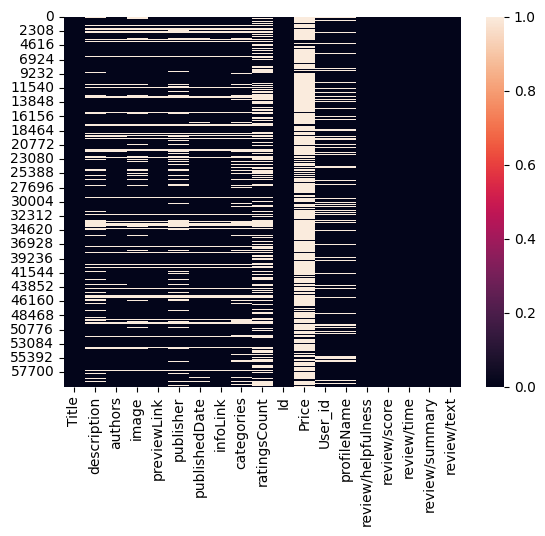

                                               Title  \
0                                       Run Baby Run   
1  Discover Your Sales Strengths: How the World's...   
2  Daily With the King: a Devotional for Self-dis...   
3               Animal Farm 50TH Anniversary Edition   
4                                               Mash   

                                         description  \
0  This is the thrilling story of Nicky Cruz's de...   
1  In the ever-changing world of sales, there is ...   
2                                                NaN   
3  A satire on totalitarianism in which farm anim...   
4  Before the movie, this is the novel that gave ...   

                               authors  \
0   ['Nicky Cruz', 'Jamie Buckingham']   
1  ['Benson Smith', 'Tony Rutigliano']   
2                                  NaN   
3                    ['George Orwell']   
4                   ['Richard Hooker']   

                                               image  \
0  http://books.g

ValueError: could not convert string to float: 'Run Baby Run'

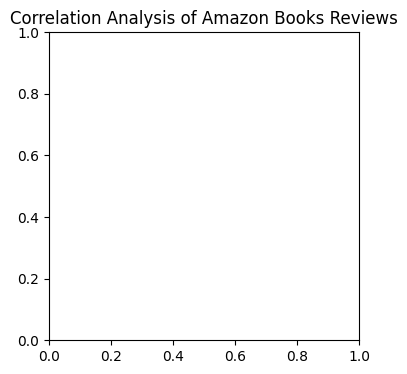

In [11]:
eda.explore()

In [12]:
eda.data_cleaning()

New dataset shape:
 (59997, 19)
Removing irrevelant variables...

New dataset columns:\ Index(['Title', 'description', 'authors', 'image', 'publisher',
       'publishedDate', 'categories', 'ratingsCount', 'User_id',
       'review/helpfulness', 'review/score', 'review/time', 'review/summary',
       'review/text'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59997 entries, 0 to 59996
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               59992 non-null  object
 1   description         47098 non-null  object
 2   authors             52124 non-null  object
 3   image               49218 non-null  object
 4   publisher           44297 non-null  object
 5   publishedDate       52900 non-null  object
 6   categories          48892 non-null  object
 7   User_id             48731 non-null  object
 8   review/helpfulness  59997 non-null  object
 9   review/summary      59985 non-null  object
 10  review/text         59997 non-null  object
dtypes: object(11)
memory usage: 5.0+ MB
Categorical and textual features:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59997 entries, 0 to 59996
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  

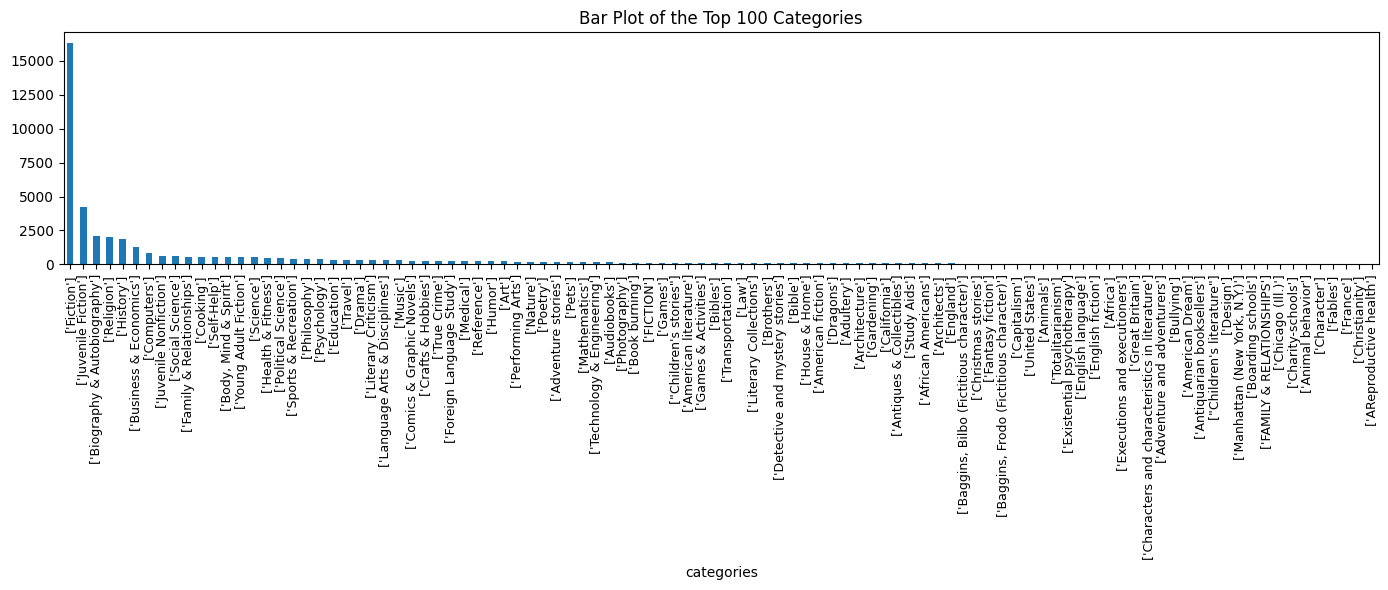

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [14]:
eda.univariate_variables()

In [15]:
eda.bivariate_analysis()

/home/vscode/.local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
'''
%cd {base_path}final_project
!git config --global --unset credential.helper
#!git config --global user.name "fernandaluft"
#!git config --global user.email "fernandaluft@gmail.com"
#!git config --global user.name "neural1977"
#!git config --global user.email "pugliese05@gmail.com"
!git add .
!git commit -m "New Final Project"
'''

'\n%cd {base_path}final_project\n!git config --global --unset credential.helper\n#!git config --global user.name "fernandaluft"\n#!git config --global user.email "fernandaluft@gmail.com"\n#!git config --global user.name "neural1977"\n#!git config --global user.email "pugliese05@gmail.com"\n!git add .\n!git commit -m "New Final Project"\n'

In [ ]:
#!git push origin main